## Sagnac Frequency - Backscatter Correction - RV Tilt

Explore the longterm behaviour of the RU sagnac beat

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data

## Configurations

In [6]:
config = {}

config['ring'] = "V"

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"

config['tbeg'] = UTCDateTime("2024-05-22 16:00")
config['tend'] = UTCDateTime("2024-06-03 00:00")

flim1, flim2 = 447.726, 447.736

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

## Configurations

In [7]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

### Compute Backscatter (again)

In [8]:
from functions.backscatter_correction import __backscatter_correction

In [10]:
# unwrap phases as one time series
bs['fj_ph'] = np.unwrap(bs.fj_ph)
bs['f1_ph'] = np.unwrap(bs.f1_ph)
bs['f2_ph'] = np.unwrap(bs.f2_ph)

# fractional beat modulations
m01 = bs.f1_ac / bs.f1_dc
m02 = bs.f2_ac / bs.f2_dc

# phase difference
ph1 = bs.f1_ph
ph2 = bs.f2_ph
phase0 = ph2 - ph1

# beat signal observed
w_obs = bs.fj_fs

# compute backscatter corrected signal
bs['fj_bs'] = __backscatter_correction(m01, m02, phase0, w_obs, np.median(bs.fj_fs), cm_filter_factor=1.033)

(447.726, 447.736)

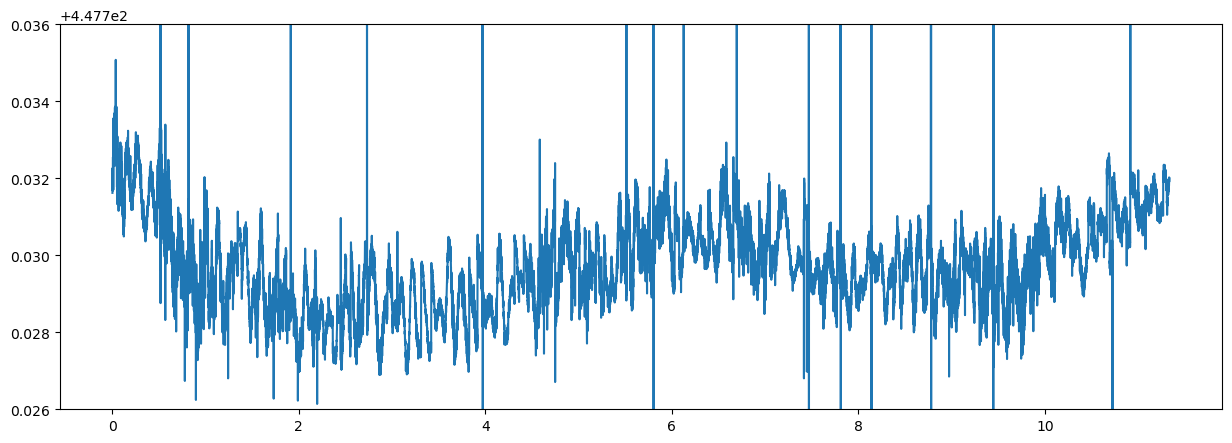

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(bs.time_sec/86400, bs.fj_fs)
plt.ylim(flim1, flim2)

### Cut corrupt data periods

In [12]:
# times = [("2023-12-04T09:11", "2023-12-04T18:01")]

# for t1, t2 in times:
#     bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
#     bs['fj_bs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.w_s)


# bs['fj_fs'] = np.nan_to_num(bs['fj_fs'], nan=np.nanmedian(bs['fj_fs']))
# bs['fj_bs'] = np.nan_to_num(bs['fj_bs'], nan=np.nanmedian(bs['fj_bs']))

In [15]:
from functions.load_mlti import __load_mlti

mlti = __load_mlti(config['tbeg'], config['tend'], config['ring'], archive_path)

In [16]:
from functions.get_mlti_intervals import __get_mlti_intervals

mlti_t1, mlti_t2 = __get_mlti_intervals(mlti.time_utc)

In [17]:
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mlti_t1, mlti_t2, t_offset_sec=300)
bs = __mlti_intervals_to_NaN(bs, "fj_bs", "time1", mlti_t1, mlti_t2, t_offset_sec=300)

### Apply special filter sections

In [22]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

In [23]:
from functions.smoothing import __smooth

n_minutes = 100

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, n_minutes)

### Load LXX maintenance

In [24]:
from functions.load_lxx import __load_lxx

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

In [25]:
from functions.get_lxx_intervals import __get_lxx_intervals

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

### Checkup Plot

/tmp/ipykernel_526325/3069509830.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


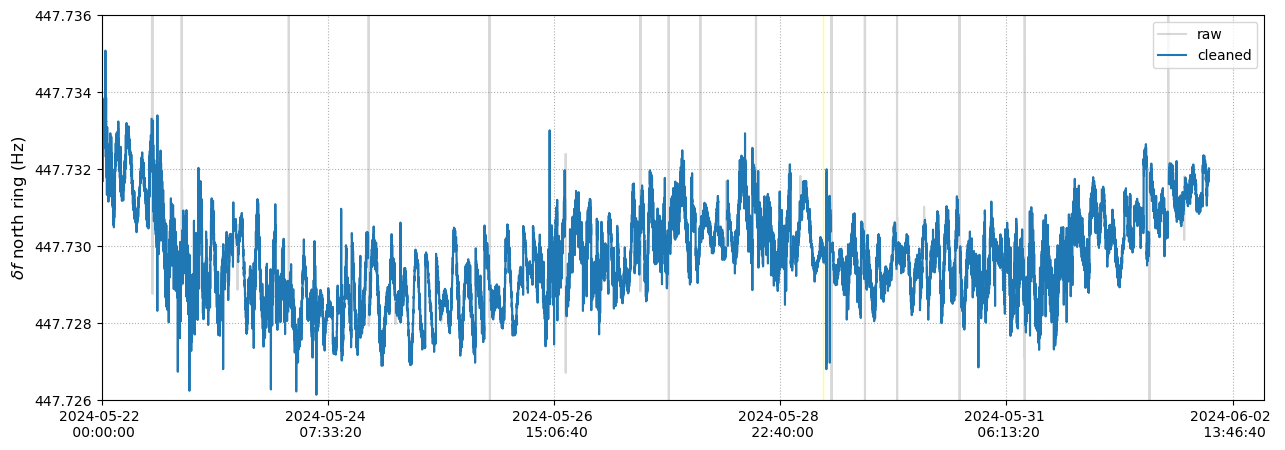

In [26]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1
    ref_date = str(bs.time1.iloc[0])[:10]

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    ax.set_xlim(left=0)

    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    ## add dates to x-axis
    tcks = ax.get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax.set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_longterm_cleaned.png", format="png", dpi=150, bbox_inches='tight')


### Load WROMY Data

In [ ]:
ws = Stream()
ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.01.LKI", config['tbeg'], config['tend'])
ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.05.LKI", config['tbeg'], config['tend'])
ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.09.LKI", config['tbeg'], config['tend'])

ws = ws.merge();

ws

### Load PROMY Data

In [ ]:
ps = Stream()
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.03.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.01.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.05.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.09.LKI", config['tbeg'], config['tend'])

ps3 = ps.merge();

ps

### Load Tilt Data

In [27]:
from functions.conversion_to_tilt import __conversion_to_tilt

In [28]:
# path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"

# tromy0 =  __read_sds(path_to_tilt, "BW.TROMY..MAN", config['tbeg']+17*86400-600, config['tend']+600)
# tromy0 += __read_sds(path_to_tilt, "BW.TROMY..MAE", config['tbeg']+17*86400-600, config['tend']+600)
# tromy0 += __read_sds(path_to_tilt, "BW.TROMY..MAT", config['tbeg']+17*86400-600, config['tend']+600)

path_to_tilt = archive_path+"romy_archive/"

tromy0 =  __read_sds(path_to_tilt, "BW.ROMYT..MAN", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAE", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAT", config['tbeg']-600, config['tend']+600)

  -> converted data of ROMYT


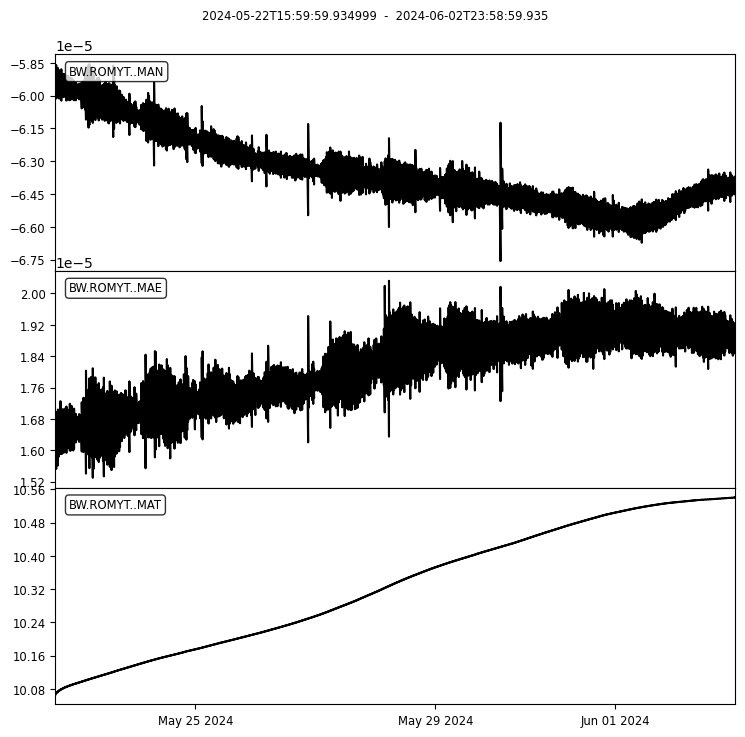

In [29]:
## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tromy0 = __conversion_to_tilt(tromy0, confTilt['TROMY'])

tromy0 = tromy0.trim(bs.time1[0], bs.time1[bs.time1.size-1]);

tromy = tromy0.copy();

tromy = tromy.merge();

tromy.plot(equal_scale=False);

In [30]:
from functions.compute_cwt import __compute_cwt
from functions.sagnac_to_tilt import __sagnac_to_tilt

In [31]:
dff = np.array(bs.fj_bs)

rx_tilt = __sagnac_to_tilt(dff, config['ring'])

rx = Stream()

rx = Trace()
rx.data = rx_tilt
rx.stats.delta = 60
rx.stats.starttime = bs.time1.iloc[0]
rx.stats.station = "ROMY"
rx.stats.channel = f"FJ{config['ring']}"
rx.stats.network = "BW"


In [32]:
st0 = Stream()

st0 += tromy.copy().select(channel="*N")[0]
st0 += tromy.copy().select(channel="*E")[0]

st0 += rx.copy()

In [33]:
pmin, pmax = 24, 10

st0 = st0.trim(config['tbeg'], config['tend'], nearest_sample=False)
st0 = st0.detrend("linear")
st0 = st0.taper(0.2)
st0 = st0.filter("bandpass", freqmin=1/(pmin*3600), freqmax=1/(pmax*3600), corners=2, zerophase=True)
st0 = st0.resample(1/600, no_filter=True)
st0 = st0.trim(config['tbeg'], config['tend']-7200, nearest_sample=True)
st0


3 Trace(s) in Stream:
BW.ROMYT..MAN | 2024-05-22T16:00:00.134999Z - 2024-06-02T22:00:00.134999Z | 600.0 s, 1621 samples
BW.ROMYT..MAE | 2024-05-22T16:00:00.134999Z - 2024-06-02T22:00:00.134999Z | 600.0 s, 1621 samples
BW.ROMY..FJV  | 2024-05-22T16:00:00.000000Z - 2024-06-02T22:00:00.000000Z | 600.0 s, 1621 samples

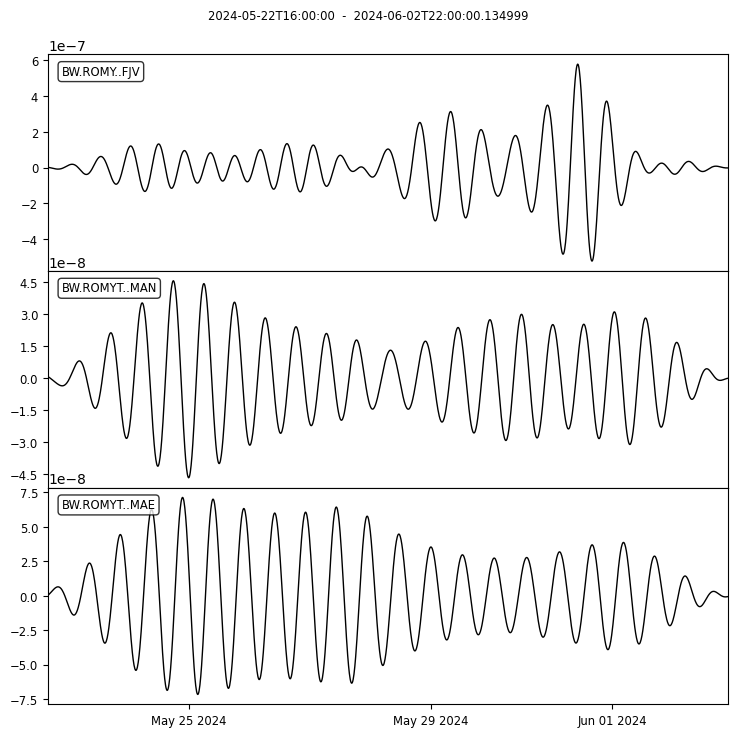

In [34]:
st0.plot(equal_scale=False);

In [36]:

outs = {}

for c in ["N", "E", config['ring']]:

    tr = st0.select(channel=f"*{c}")[0]

    ttt = tr.times()
    arr = tr.data
    dt  = tr.stats.delta # seconds

    outs[c] = __compute_cwt(ttt, arr, dt,
                            tscale="hour",
                            datalabel="$\delta$f (Hz)",
                            scale_value=2,
                            log=False, period=True, ymax=30, plot=False,
                           )

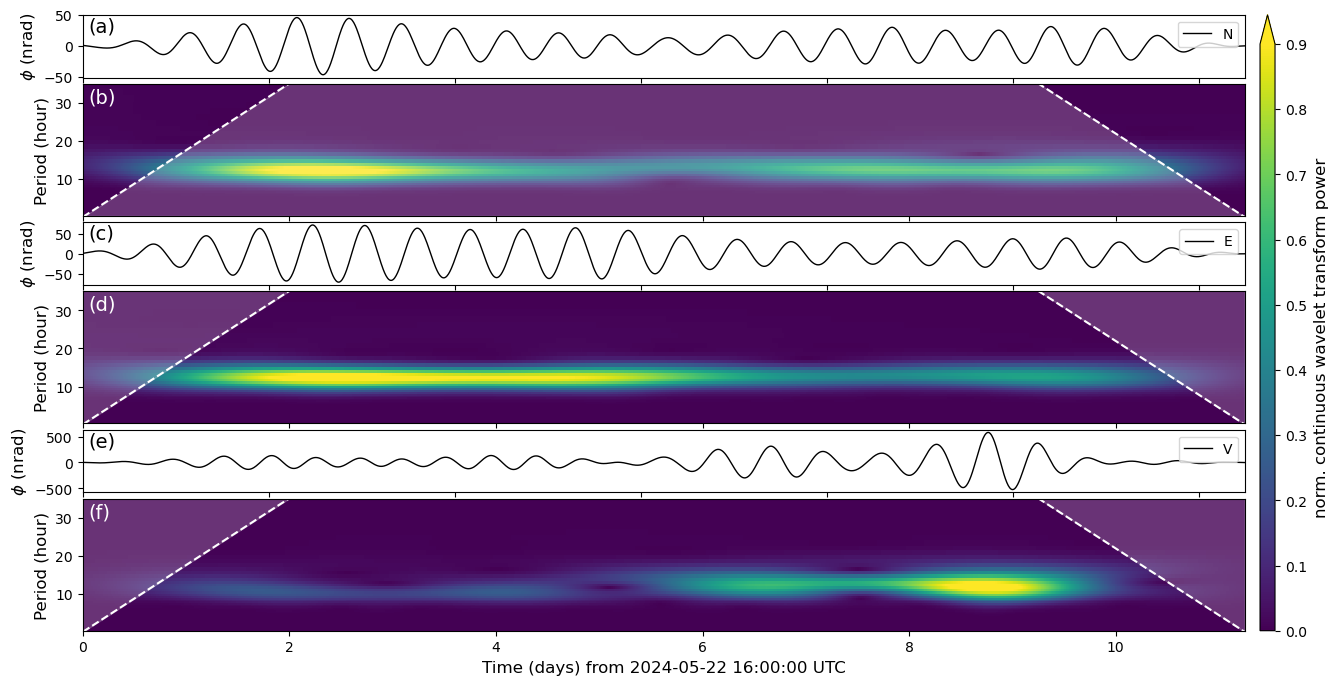

In [42]:
def __makeplot_cwt_all(st0, out, clog=False, ylim=None):

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 2)

    tscale = 1/86400

    times = st0.select(channel="*N")[0].times()*tscale/3600

    Ncol, Nrow = 1, 9

    font = 12

    cmap = plt.get_cmap("viridis")

    tilt_scale, tilt_unit = 1e9, f"nrad"

    fig = plt.figure(figsize=(15, 8))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.1)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1:3, :])
    ax3 = fig.add_subplot(gs[3, :])
    ax4 = fig.add_subplot(gs[4:6, :])
    ax5 = fig.add_subplot(gs[6, :])
    ax6 = fig.add_subplot(gs[7:9, :])

    axes = [ax1, ax2, ax3, ax4, ax5, ax6]

    U = st0.select(channel=f"*{config['ring']}")[0].data*tilt_scale
    N = st0.select(channel="*N")[0].data*tilt_scale
    E = st0.select(channel="*E")[0].data*tilt_scale

    periodZ = 1/outs[config['ring']]['frequencies']/3600
    periodN = 1/outs['N']['frequencies']/3600
    periodE = 1/outs['N']['frequencies']/3600

    # _______________________________________________________________
    #
    ax1.plot(times, N, color="k", label="N", lw=1)
    ax1.set_xlim(min(times), max(times))
    ax1.legend(loc=1)
    ax1.set_xticklabels([])

    if clog:
        vmin, vmax, norm = 0.01, 1, "log"
    else:
        vmin, vmax, norm = 0.0, 0.9, None
    # _______________________________________________________________
    #
    im1 = ax2.pcolormesh(out['N']['times']*tscale*3600, periodN, out['N']['cwt_power'],
                         cmap=cmap,
                         vmin=vmin,
                         vmax=vmax,
                         norm=norm,
                        )
    ax2.plot(out['N']['times']*tscale*3600, 1/out['N']['cone']/3600, color="white", ls="--")
    ax2.fill_between(out['N']['times']*tscale*3600, 1/out['N']['cone']/3600, min(periodN)*np.ones(len(out['N']['cone'])), color="white", alpha=0.2)
    ax2.set_xticklabels([])

    if ylim is None:
        ax2.set_ylim(min(periodN), max(periodN))
    else:
        ax2.set_ylim(min(periodN), ylim)

    # _______________________________________________________________
    #
    ax3.plot(times, E, color="k", label="E", lw=1)
    ax3.set_xlim(min(times), max(times))
    ax3.legend(loc=1)
    ax3.set_xticklabels([])

    # _______________________________________________________________
    #
    im2 = ax4.pcolormesh(out['E']['times']*tscale*3600, periodE, out['E']['cwt_power'],
                         cmap=cmap,
                         vmin=vmin,
                         vmax=vmax,
                         norm=norm,
                        )
    ax4.plot(out['E']['times']*tscale*3600, 1/out['E']['cone']/3600, color="white", ls="--")
    ax4.fill_between(out['E']['times']*tscale*3600, 1/out['E']['cone']/3600, max(periodE)*np.ones(len(out['E']['cone'])), color="white", alpha=0.2)
    ax4.set_xticklabels([])

    if ylim is None:
        ax4.set_ylim(min(periodE), max(periodE))
    else:
        ax4.set_ylim(min(periodE), ylim)

    # _______________________________________________________________
    #
    ax5.plot(times, U, color="k", label=config['ring'], lw=1)
    ax5.set_xlim(min(times), max(times))
    ax5.legend(loc=1)
    ax5.set_xticklabels([])

    # _______________________________________________________________
    #
    im3 = ax6.pcolormesh(out[config['ring']]['times']*tscale*3600, periodE, out[config['ring']]['cwt_power'],
                         cmap=cmap,
                         vmin=vmin,
                         vmax=vmax,
                         norm=norm,
                        )
    ax6.plot(out[config['ring']]['times']*tscale*3600, 1/out[config['ring']]['cone']/3600, color="white", ls="--")
    ax6.fill_between(out[config['ring']]['times']*tscale*3600, 1/out[config['ring']]['cone']/3600, max(periodZ)*np.ones(len(out[config['ring']]['cone'])), color="white", alpha=0.2)

    if ylim is None:
        ax6.set_ylim(min(periodZ), max(periodZ))
    else:
        ax6.set_ylim(min(periodZ), ylim)

    # _______________________________________________________________
    #
    ax1.set_ylabel(f"$\phi$ ({tilt_unit})", fontsize=font)
    ax2.set_ylabel(f"Period (hour)", fontsize=font)
    ax3.set_ylabel(f"$\phi$ ({tilt_unit})", fontsize=font)
    ax4.set_ylabel(f"Period (hour)", fontsize=font)
    ax5.set_ylabel(f"$\phi$ ({tilt_unit})", fontsize=font)
    ax6.set_ylabel(f"Period (hour)", fontsize=font)

    ax6.set_xlabel(f"Time (days) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)


    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2, color="w")
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2, color="w")
    ax5.text(.005, .97, "(e)", ha='left', va='top', transform=ax5.transAxes, fontsize=font+2)
    ax6.text(.005, .97, "(f)", ha='left', va='top', transform=ax6.transAxes, fontsize=font+2, color="w")

    # add colorbar
    cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im1, cax=cbar_ax, extend="max")
    cb.set_label("norm. continuous wavelet transform power", fontsize=font, labelpad=5, color="black")

#     ax1.set_title(f"bandpass = {pmax} - {pmin} hours")

    plt.plot();
    return fig

fig = __makeplot_cwt_all(st0, outs, clog=False, ylim=35)


### Load Infrasound FFBI

In [43]:
ffbi = __read_sds(bay_path+"mseed_online/archive/", "BW.FFBI..BDF", config['tbeg'], config['tend'])

if len(ffbi) != 2:
    ffbi.merge();

ffbi_inv = read_inventory(root_path+"/Documents/ROMY/ROMY_infrasound/station_BW_FFBI.xml")
ffbi = ffbi.remove_response(ffbi_inv, water_level=10)

ffbi += __read_sds(bay_path+"mseed_online/archive/", "BW.FFBI..BDO", config['tbeg'], config['tend'])
for tr in ffbi:
    if "O" in tr.stats.station:
        tr.data = tr.data /1.0 /6.28099e5 /100e-3   # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity = 100 mV/hPa

ffbi.plot(equal_scale=False);

 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


KeyboardInterrupt: 

In [ ]:
ru_tilt = __sagnac_to_tilt(np.array(bs.fj_bs_inter), config['ring'])

ru = Stream()

ru = Trace()
ru.data = ru_tilt
ru.stats.delta = 60
ru.stats.starttime = bs.time1.iloc[0]
ru.stats.station = "ROMY"
ru.stats.channel = f"FJ{config['ring']}"
ru.stats.network = "BW"


In [ ]:
st0 = Stream()

st0 += ffbi.select(channel="*F")[0].copy()
st0 += ffbi.select(channel="*O")[0].copy()

st0 += ru.copy()

In [ ]:
st0.plot(equal_scale=False)

In [ ]:
fmin, fmax = 1/3600, 0.01

st0 = st0.trim(config['tbeg'], config['tend'], nearest_sample=False)
st0 = st0.detrend("linear")
st0 = st0.taper(0.1)
st0 = st0.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)
st0 = st0.resample(5*fmax, no_filter=True)
st0 = st0.trim(config['tbeg'], config['tend']-7200, nearest_sample=True)
st0


In [ ]:

outs = {}

for c in ["O", "F", "U"]:

    tr = st0.select(channel=f"*{c}")[0]

    ttt = tr.times()
    arr = tr.data
    dt  = tr.stats.delta # seconds

    outs[c] = __compute_cwt(ttt, arr, dt,
                            tscale="hour",
                            datalabel="$\delta$f (Hz)",
                            scale_value=10,
                            log=False, period=True, ymax=None, plot=True,
                           )

In [ ]:
def __makeplot_cwt_all(st0, out, clog=False, ylim=None):

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 2)

    tscale = 1/86400

    times = st0.select(channel="*O")[0].times()*tscale/3600

    Ncol, Nrow = 1, 9

    font = 12

    cmap = plt.get_cmap("viridis")

    # tilt_scale, tilt_unit = 1e9, f"nrad"

    fig = plt.figure(figsize=(15, 8))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.1)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1:3, :])
    ax3 = fig.add_subplot(gs[3, :])
    ax4 = fig.add_subplot(gs[4:6, :])
    ax5 = fig.add_subplot(gs[6, :])
    ax6 = fig.add_subplot(gs[7:9, :])

    axes = [ax1, ax2, ax3, ax4, ax5, ax6]

    U = st0.select(channel="*U")[0].data
    O = st0.select(channel="*O")[0].data
    F = st0.select(channel="*F")[0].data

    periodZ = 1/outs['U']['frequencies']/3600
    periodN = 1/outs['O']['frequencies']/3600
    periodE = 1/outs['F']['frequencies']/3600

    # _______________________________________________________________
    #
    ax1.plot(times, O, color="k", label="BDO", lw=1)
    ax1.set_xlim(min(times), max(times))
    ax1.legend(loc=1)
    ax1.set_xticklabels([])

    if clog:
        vmin, vmax, norm = 0.01, 1, "log"
    else:
        vmin, vmax, norm = 0.0, 0.9, None
    # _______________________________________________________________
    #
    im1 = ax2.pcolormesh(out['O']['times']*tscale*3600, periodN, out['O']['cwt_power'],
                         cmap=cmap,
                         vmin=vmin,
                         vmax=vmax,
                         norm=norm,
                        )
    ax2.plot(out['O']['times']*tscale*3600, 1/out['O']['cone']/3600, color="white", ls="--")
    ax2.fill_between(out['O']['times']*tscale*3600, 1/out['O']['cone']/3600, min(periodN)*np.ones(len(out['O']['cone'])), color="white", alpha=0.2)
    ax2.set_xticklabels([])

    if ylim is None:
        ax2.set_ylim(min(periodN), max(periodN))
    else:
        ax2.set_ylim(min(periodN), ylim)

    # _______________________________________________________________
    #
    ax3.plot(times, F, color="k", label="BDF", lw=1)
    ax3.set_xlim(min(times), max(times))
    ax3.legend(loc=1)
    ax3.set_xticklabels([])

    # _______________________________________________________________
    #
    im2 = ax4.pcolormesh(out['F']['times']*tscale*3600, periodE, out['F']['cwt_power'],
                         cmap=cmap,
                         vmin=vmin,
                         vmax=vmax,
                         norm=norm,
                        )
    ax4.plot(out['F']['times']*tscale*3600, 1/out['F']['cone']/3600, color="white", ls="--")
    ax4.fill_between(out['F']['times']*tscale*3600, 1/out['F']['cone']/3600, max(periodE)*np.ones(len(out['F']['cone'])), color="white", alpha=0.2)
    ax4.set_xticklabels([])

    if ylim is None:
        ax4.set_ylim(min(periodE), max(periodE))
    else:
        ax4.set_ylim(min(periodE), ylim)

    # _______________________________________________________________
    #
    ax5.plot(times, U*1e9, color="k", label="FJU", lw=1)
    ax5.set_xlim(min(times), max(times))
    ax5.legend(loc=1)
    ax5.set_xticklabels([])

    # _______________________________________________________________
    #
    im3 = ax6.pcolormesh(out['U']['times']*tscale*3600, periodE, out['U']['cwt_power'],
                         cmap=cmap,
                         vmin=vmin,
                         vmax=vmax,
                         norm=norm,
                        )
    ax6.plot(out['U']['times']*tscale*3600, 1/out['U']['cone']/3600, color="white", ls="--")
    ax6.fill_between(out['U']['times']*tscale*3600, 1/out['U']['cone']/3600, max(periodZ)*np.ones(len(out['U']['cone'])), color="white", alpha=0.2)

    if ylim is None:
        ax6.set_ylim(min(periodZ), max(periodZ))
    else:
        ax6.set_ylim(min(periodZ), ylim)

    # _______________________________________________________________
    #
    ax1.set_ylabel(f"P (Pa)", fontsize=font)
    ax2.set_ylabel(f"Period (hour)", fontsize=font)
    ax3.set_ylabel(f"P (Pa)", fontsize=font)
    ax4.set_ylabel(f"Period (hour)", fontsize=font)
    ax5.set_ylabel(f"$\Omega$ (nrad)", fontsize=font)
    ax6.set_ylabel(f"Period (hour)", fontsize=font)

    ax6.set_xlabel(f"Time (days) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)


    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2, color="w")
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2, color="w")
    ax5.text(.005, .97, "(e)", ha='left', va='top', transform=ax5.transAxes, fontsize=font+2)
    ax6.text(.005, .97, "(f)", ha='left', va='top', transform=ax6.transAxes, fontsize=font+2, color="w")

    # add colorbar
    cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im1, cax=cbar_ax, extend="max")
    cb.set_label("norm. continuous wavelet transform power", fontsize=font, labelpad=5, color="black")

#     ax1.set_title(f"bandpass = {pmax} - {pmin} hours")

    plt.plot();
    return fig

fig = __makeplot_cwt_all(st0, outs, clog=False, ylim=None)


## Plotting